In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from re import sub

In [3]:
expression_data = pd.read_csv("20220707 cluster df.csv").set_index('GENE_SYMBOLS')

In [4]:
with open('C:/Users/mbzjim/OneDrive - The University of Nottingham/Other Bioinformatics/transporter genes from tcdb.txt') as f:
    transporter_genes_in = f.readlines()

In [5]:
gene_name_only = [x.split(' ')[0] for x in transporter_genes_in]
gene_name_only = [sub('\n', '', x) for x in gene_name_only]
gene_name_only[:5]

['ANXA1', 'ANXA10', 'ANXA11', 'ANXA13', 'ANXA2']

In [6]:
transporters_in_dataset = expression_data.index[expression_data.index.isin(gene_name_only)]
expression_data_transporters = expression_data.loc[transporters_in_dataset].drop('Cluster', axis = 1)
expression_data_transporters.head()

,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,DATA.1240135,DATA.1290812,DATA.907045,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
GENE_SYMBOLS,,,,,,,,,,,,,,,,,,,,,
SLC7A2,3.772923,2.970675,2.952460,3.257181,5.221305,7.114897,2.944353,3.869667,3.213857,4.561335,...,3.508247,3.126612,2.964527,4.937733,5.297539,3.181690,5.860539,6.303593,5.558363,6.559778
SLC22A16,3.054600,3.155656,3.914216,3.037781,2.917998,3.120582,3.067728,2.946315,2.958104,3.041405,...,3.247622,3.271421,3.175309,3.189752,3.171860,3.185994,3.283749,3.205749,3.515831,3.323341
ABCB5,2.915914,2.905021,2.852110,2.840624,3.161982,3.155619,2.918450,2.977183,2.861215,3.078192,...,2.921963,2.983086,2.844006,3.135612,2.874668,3.066860,2.896165,3.055759,2.853444,3.964832
SLC25A13,5.682413,4.724554,8.167217,8.577766,6.680573,8.572109,6.784076,7.502446,5.787488,6.391282,...,6.864503,6.314665,4.538141,6.670404,7.785888,5.378102,7.115999,5.914517,6.855379,7.362346
SLC4A1,2.986255,3.025523,2.932107,3.119958,3.050681,3.036392,3.005412,2.844388,2.827776,2.851267,...,3.337302,3.121964,2.971392,2.886174,3.041131,3.033495,3.068490,3.179547,3.096751,2.951820


In [7]:
ic50_data = pd.read_csv("20220708 ic50 data over 800 tests.csv").set_index('Unnamed: 0')
ic50_data

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
Unnamed: 0,,,,,,,,,,,,,,,,,,,
16289,GDSC1,281,12974445,683665,MC-CAR,SIDM00636,MM,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-3.034484,0.452038,0.060070,-0.755325
16290,GDSC1,281,12974777,683667,PFSK-1,SIDM01132,MB,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-1.044439,0.757600,0.109066,0.462049
16291,GDSC1,281,12975078,684052,A673,SIDM00848,UNCLASSIFIED,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-1.543381,0.695508,0.060342,0.156831
16292,GDSC1,281,12975390,684055,ES3,SIDM00265,UNCLASSIFIED,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-2.938496,0.469907,0.114231,-0.696606
16293,GDSC1,281,12975743,684057,ES5,SIDM00263,UNCLASSIFIED,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-1.484649,0.679877,0.204723,0.192759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310899,GDSC1,281,13269726,1660034,SNU-407,SIDM00214,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.000,4.820567,0.975376,0.032752,0.299720
310900,GDSC1,281,13269986,1660035,SNU-61,SIDM00194,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.000,5.785978,0.977001,0.040082,1.742423
310901,GDSC1,281,13270253,1660036,SNU-81,SIDM00193,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.000,5.393454,0.979140,0.042595,1.155838


In [8]:
cells = [int(x.split('.')[1]) for x in expression_data.drop('Cluster', axis = 1).columns]

cell_id_matches = []

for cell_id in cells:
    if cell_id in ic50_data['COSMIC_ID'].values:
        cell_id_matches.append(cell_id)
        
print(f'Number of matches: {len(cell_id_matches)} of {len(cells)}')

Number of matches: 959 of 1018


In [9]:
expression_matches = np.isin(np.array(cells), np.array(cell_id_matches))

expr_matched = expression_data.drop('Cluster', axis = 1).iloc[:,expression_matches]
expr_matched.shape

(17419, 959)

In [10]:
ic50_matched = ic50_data.loc[ic50_data['COSMIC_ID'].isin(cell_id_matches)]
ic50_matched

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
Unnamed: 0,,,,,,,,,,,,,,,,,,,
16289,GDSC1,281,12974445,683665,MC-CAR,SIDM00636,MM,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-3.034484,0.452038,0.060070,-0.755325
16290,GDSC1,281,12974777,683667,PFSK-1,SIDM01132,MB,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-1.044439,0.757600,0.109066,0.462049
16291,GDSC1,281,12975078,684052,A673,SIDM00848,UNCLASSIFIED,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-1.543381,0.695508,0.060342,0.156831
16292,GDSC1,281,12975390,684055,ES3,SIDM00265,UNCLASSIFIED,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-2.938496,0.469907,0.114231,-0.696606
16293,GDSC1,281,12975743,684057,ES5,SIDM00263,UNCLASSIFIED,133,Doxorubicin,Anthracycline,DNA replication,1045,Y,0.004000,1.024,-1.484649,0.679877,0.204723,0.192759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310898,GDSC1,281,13269334,1659823,SNU-1040,SIDM00217,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.000,5.353963,0.977047,0.038387,1.096822
310899,GDSC1,281,13269726,1660034,SNU-407,SIDM00214,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.000,4.820567,0.975376,0.032752,0.299720
310900,GDSC1,281,13269986,1660035,SNU-61,SIDM00194,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.000,5.785978,0.977001,0.040082,1.742423



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


316 of 316 with over 800 cells tested


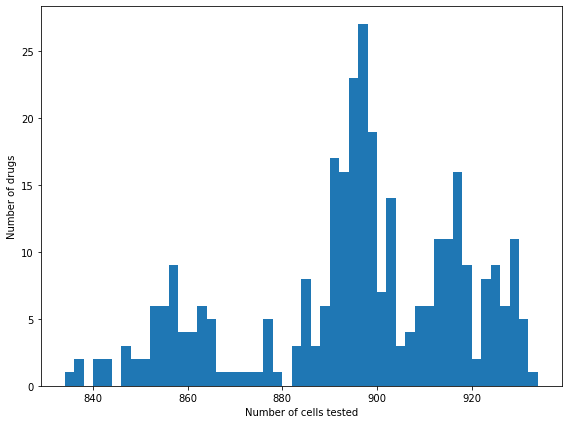

In [11]:
ic50_smaller = ic50_matched[['COSMIC_ID', 'DRUG_ID', 'DRUG_NAME']]
ic50_smaller['Count'] = 1
test_counts = ic50_smaller.groupby('DRUG_ID').agg('sum').Count

fig, ax = plt.subplots(figsize = (8,6))
ax.hist(test_counts, bins = 50)
ax.set_xlabel('Number of cells tested')
ax.set_ylabel('Number of drugs')
plt.tight_layout()
number_drugs = len(ic50_data.DRUG_ID.unique())
drugs_over_800 = sum(test_counts > 800)
print(f'{drugs_over_800} of {number_drugs} with over 800 cells tested')

In [12]:
expr_matched_transporters = expr_matched.loc[expression_data_transporters.index].T
expr_matched_transporters['COSMIC_ID'] = [int(x.split('.')[1]) for x in expr_matched_transporters.index]
expr_matched_transporters

GENE_SYMBOLS,SLC7A2,SLC22A16,ABCB5,SLC25A13,SLC4A1,SLC25A5,ABCB4,ABCC8,CACNG3,CACNA1G,...,KCNU1,SLC35E2,ANXA2P3,SLC12A8,SLC26A6,ABCC13,ATP6V1E2,SLC10A5,SLC5A8,COSMIC_ID
DATA.906826,3.772923,3.054600,2.915914,5.682413,2.986255,11.938730,2.850470,3.234098,3.217366,3.090077,...,2.927092,5.130214,5.718174,3.886461,4.995954,2.752484,4.132229,2.783807,2.835125,906826
DATA.687983,2.970675,3.155656,2.905021,4.724554,3.025523,11.202165,2.840188,3.279462,3.231568,3.167001,...,3.044569,4.937874,4.165511,3.064715,6.033095,2.751345,5.886918,2.947635,2.719290,687983
DATA.910927,2.952460,3.914216,2.852110,8.167217,2.932107,11.827920,2.825953,2.945546,3.088170,2.927685,...,2.911594,3.839201,4.848977,3.820806,5.392681,2.838933,5.291615,2.997918,2.639684,910927
DATA.1240138,3.257181,3.037781,2.840624,8.577766,3.119958,11.523839,2.885305,3.205181,3.253679,2.988769,...,2.859698,4.476318,6.438741,8.411417,4.666385,2.794513,5.028543,3.035158,2.862140,1240138
DATA.1240139,5.221305,2.917998,3.161982,6.680573,3.050681,11.987958,3.173159,3.176796,2.957431,3.066732,...,3.018705,4.410335,5.439287,3.314831,4.437482,2.701077,4.569673,2.821759,2.758902,1240139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DATA.1298157,3.181690,3.185994,3.066860,5.378102,3.033495,12.119355,2.905892,2.936090,2.995564,3.027004,...,3.088158,4.180514,5.465631,4.145424,5.542568,2.689188,5.179688,2.719621,2.784360,1298157
DATA.1480372,5.860539,3.283749,2.896165,7.115999,3.068490,12.426098,3.009029,3.008853,3.160544,2.965887,...,2.749092,4.037287,4.711590,4.220567,4.542944,2.822476,5.405698,2.761887,2.832824,1480372
DATA.1298533,6.303593,3.205749,3.055759,5.914517,3.179547,11.016405,2.912401,3.078480,3.425870,3.024715,...,2.958232,5.061742,4.908687,3.499278,5.697980,2.924394,4.305439,2.799328,2.885522,1298533
DATA.930299,5.558363,3.515831,2.853444,6.855379,3.096751,12.265825,5.805306,6.421057,3.105036,3.121989,...,2.855941,3.922998,3.983569,4.332256,4.718458,2.816630,3.280221,2.917049,2.992348,930299


In [13]:
def model_drug(drug, cluster_df, verbose = False, figure = False):
    ic50_sub = ic50_matched.loc[ic50_matched['DRUG_NAME'] == drug][['COSMIC_ID',
                                                                    'LN_IC50',
                                                                    'Z_SCORE']]
    df = pd.merge(ic50_sub, cluster_df).set_index('COSMIC_ID')
    
    X = df.drop(['LN_IC50', 'Z_SCORE'], axis = 1)
    y = df['LN_IC50']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    train_data = lightgbm.Dataset(X_train, label = y_train)
    test_data = lightgbm.Dataset(X_test, label = y_test, reference = train_data)
    
    param = {'boosting_type': 'goss',
             'n_estimators': 500,
             'num_iterations': 500,
             'learning_rate': 0.05,
             'max_bin': 1024,
             'metric': 'l2',
             'objective': 'regression',
             'num_leaves': 80,
             'verbose': -1}
    
    bst = lightgbm.train(param,
                         train_data,
                         callbacks=[lightgbm.early_stopping(stopping_rounds=30, verbose = False)],
                         valid_sets = test_data)
    
    fit_predict = bst.predict(X_test)
    if verbose:
        mae = mean_absolute_error(fit_predict, y_test)
        test_range = max(y_test)-min(y_test)
        print(f'{drug}:\nMAE = {mae:.3} (range {test_range:.3})')
    if figure:
        fig, ax = plt.subplots(figsize = (16,8), ncols = 2)
        ax[0].axline((np.mean(fit_predict), np.mean(fit_predict)), slope = 1, ls = '--', color = 'red')
        ax[0].scatter(y_test, fit_predict, color = 'black', alpha = 0.5)
        ax[0].ylabel = 'Predicted ln(IC50)'
        ax[0].xlabel = 'True ln(IC50)'
        ax[0].set_title(drug)
        lightgbm.plot_importance(bst, max_num_features=20, ax = ax[1])
        if figure == 'save':
            filename = sub('[^A-Za-z0-9-]+', '', drug)
            plt.savefig(f'LGBM transporter genes/{filename}.png')
    return bst, fit_predict, y_test

def plot_test(drug):
    bst, fit_predict, y_test = all_models[drug]
    fig, ax = plt.subplots(figsize = (16,8), ncols = 2)
    ax[0].axline((np.mean(fit_predict), np.mean(fit_predict)), slope = 1, ls = '--', color = 'red')
    ax[0].scatter(y_test, fit_predict, color = 'black', alpha = 0.5)
    ax[0].ylabel = 'Predicted ln(IC50)'
    ax[0].xlabel = 'True ln(IC50)'
    ax[0].set_title(drug)
    lightgbm.plot_importance(bst, max_num_features=20, ax = ax[1])

In [14]:
all_models = dict()

for drug in ic50_matched['DRUG_NAME'].unique():
    all_models[drug] = model_drug(drug, expr_matched_transporters, verbose = False, figure = False)
    plt.close()

Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in 

In [15]:
def r_squared(predicted, true):
    mean = np.mean(true)
    true_diff_sq = np.square(true - mean)
    pred_diff_sq = np.square(true - predicted)
    return 1-(np.sum(pred_diff_sq)/np.sum(true_diff_sq))

models_r_sq = dict([(x, r_squared(y[1], y[2])) for x, y in all_models.items()])

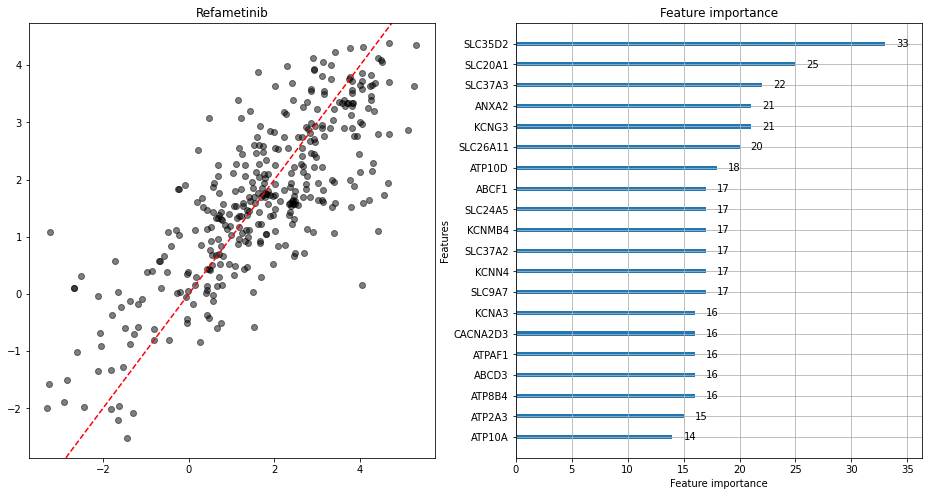

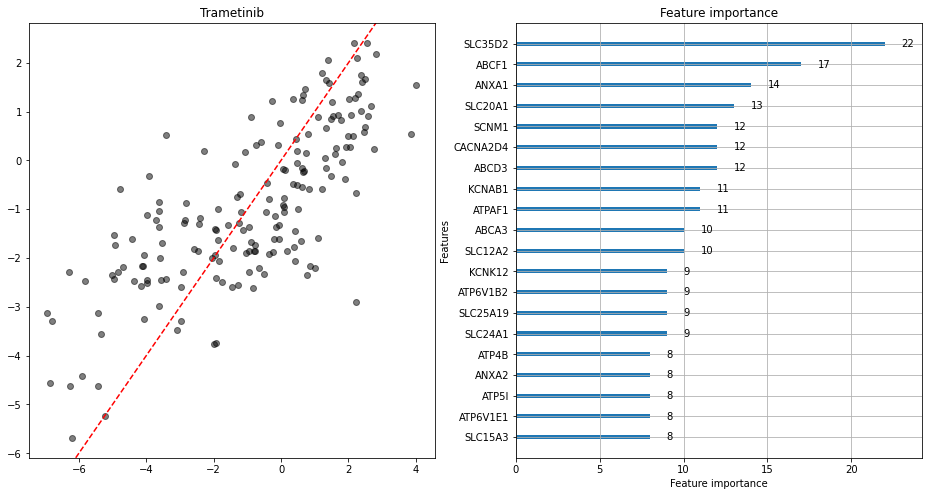

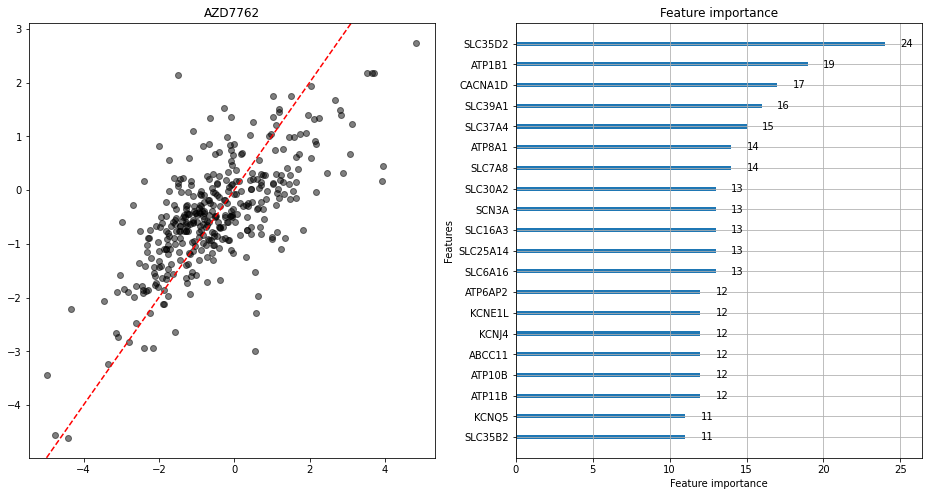

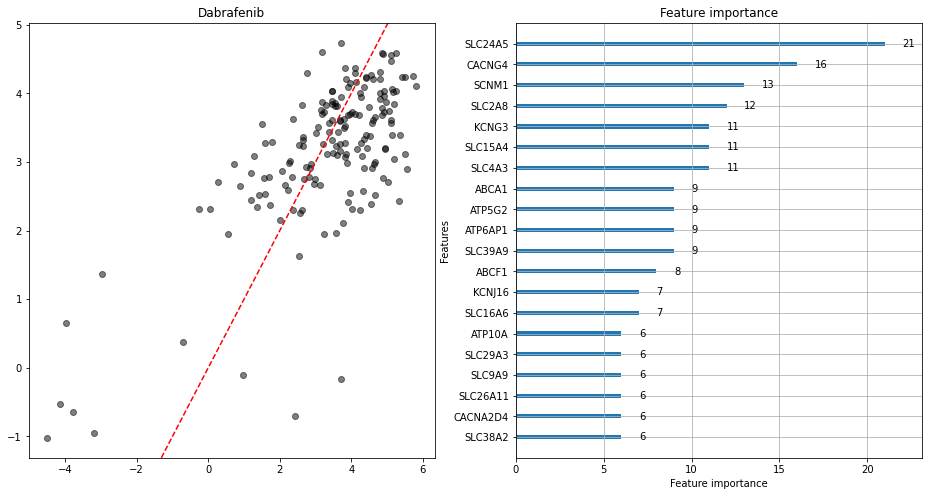

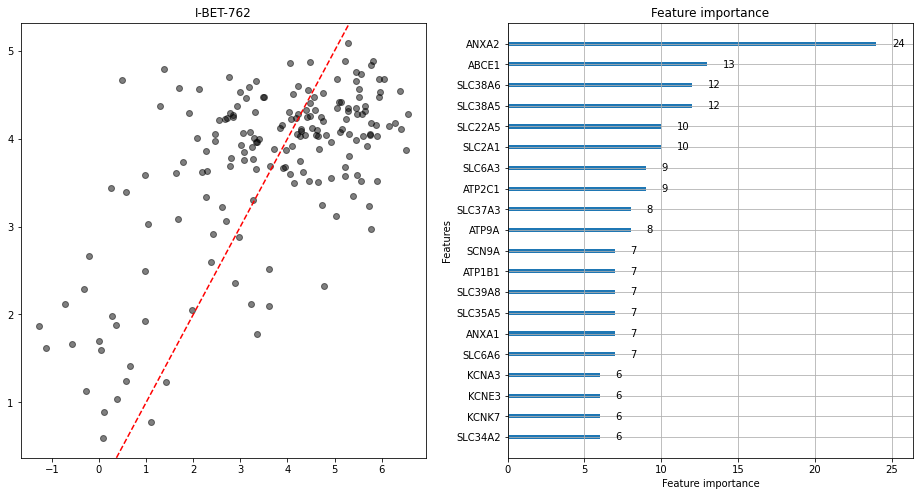

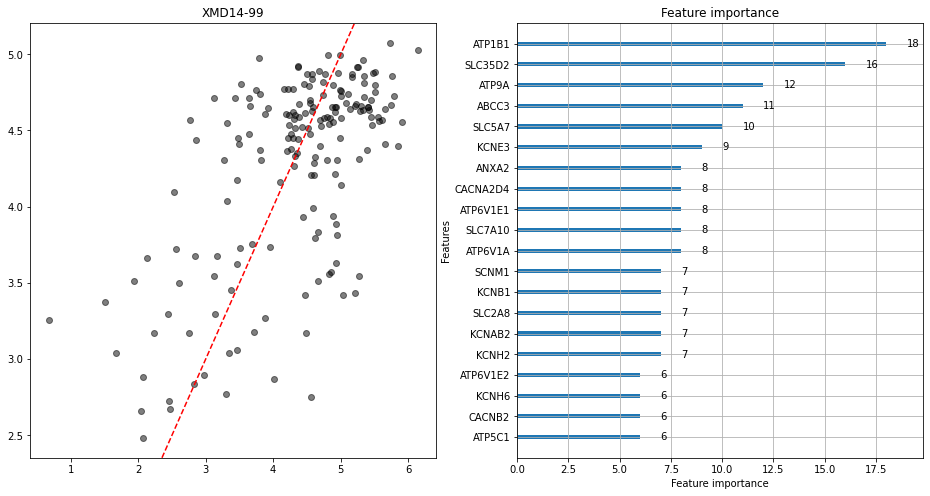

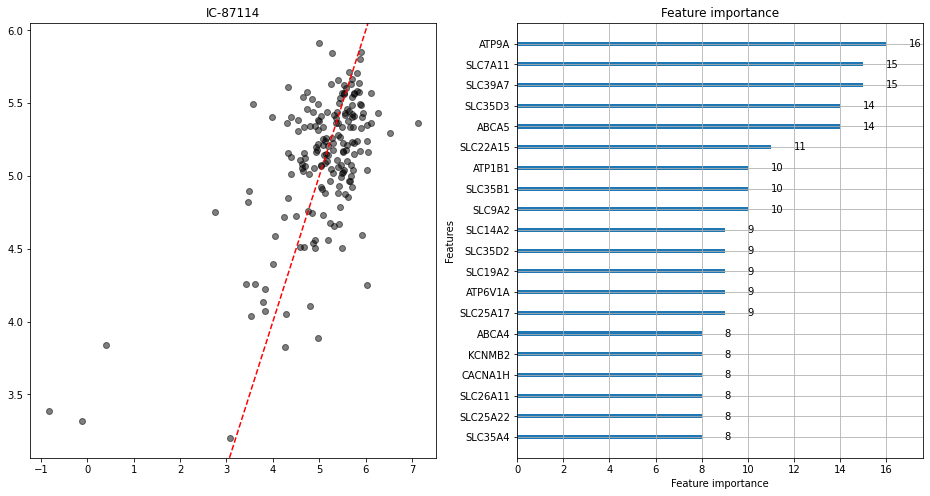

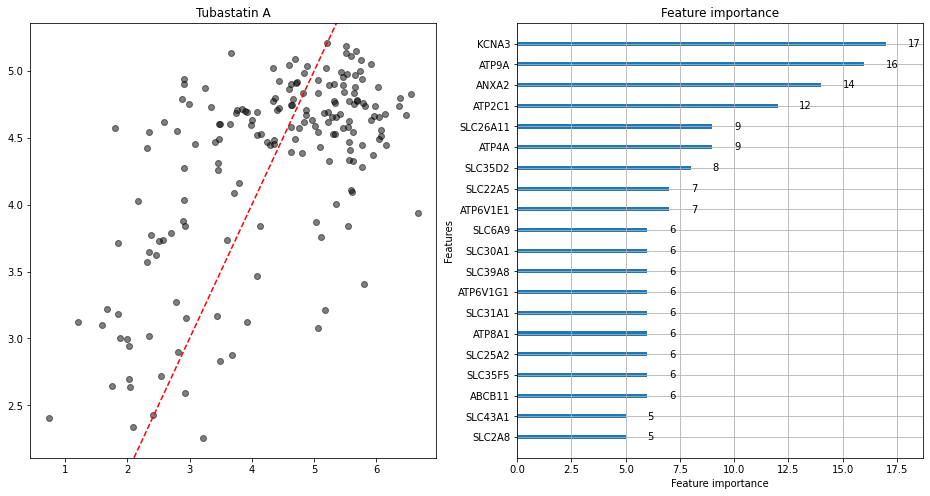

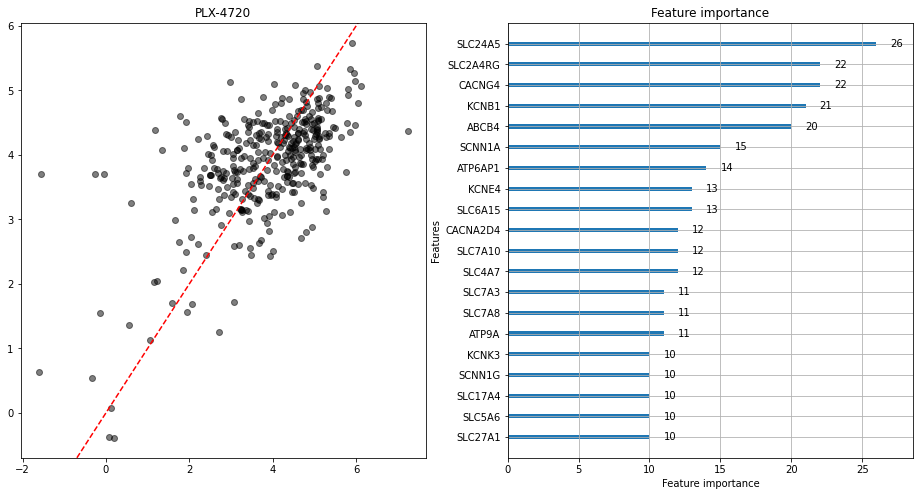

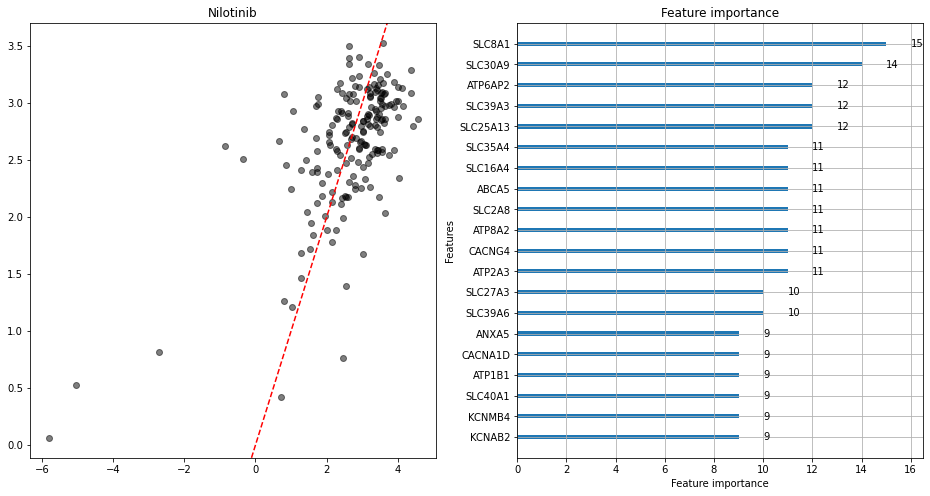

In [16]:
for drug in pd.Series(models_r_sq).sort_values(ascending = False)[:10].index:
    plot_test(drug)

In [17]:
pd.Series(models_r_sq).to_csv('20220726 transporters.csv')
pd.Series(models_r_sq).sort_values(ascending = False)[:10]

Refametinib     0.635658
Trametinib      0.554715
AZD7762         0.488041
Dabrafenib      0.478307
I-BET-762       0.392861
XMD14-99        0.378763
IC-87114        0.378046
Tubastatin A    0.371614
PLX-4720        0.370817
Nilotinib       0.370789
dtype: float64

In [47]:
def prep_data(drug):
    ic50_sub = ic50_matched.loc[ic50_matched['DRUG_NAME'] == drug][['COSMIC_ID',
                                                                    'LN_IC50',
                                                                    'Z_SCORE']]
    df = pd.merge(ic50_sub, expr_matched_transporters).set_index('COSMIC_ID')
    
    return df.drop(['LN_IC50', 'Z_SCORE'], axis = 1)

def plot_shap(drug):
    model = all_models[drug][0]
    X = prep_data(drug)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, title = drug)

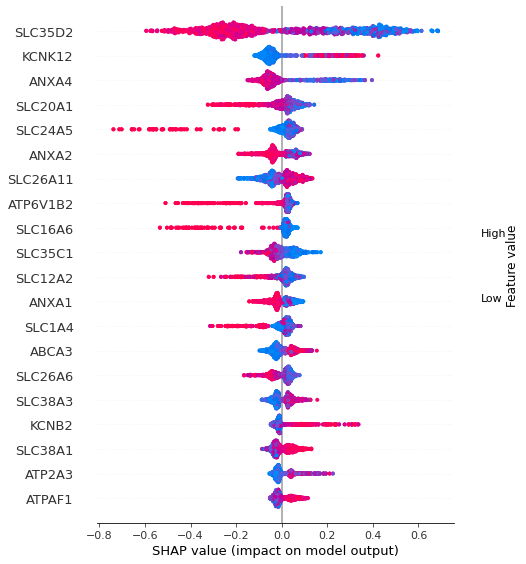

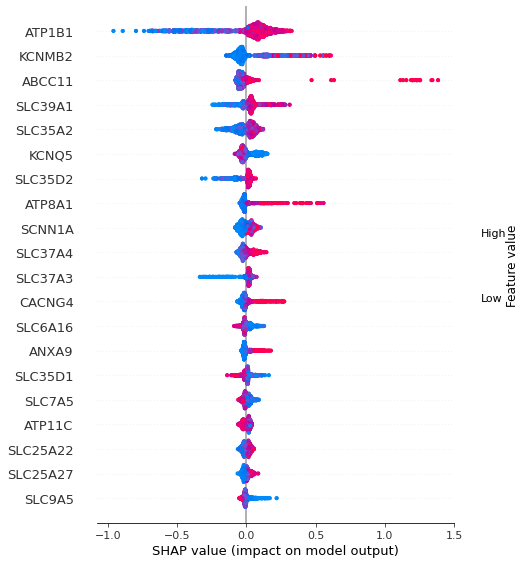

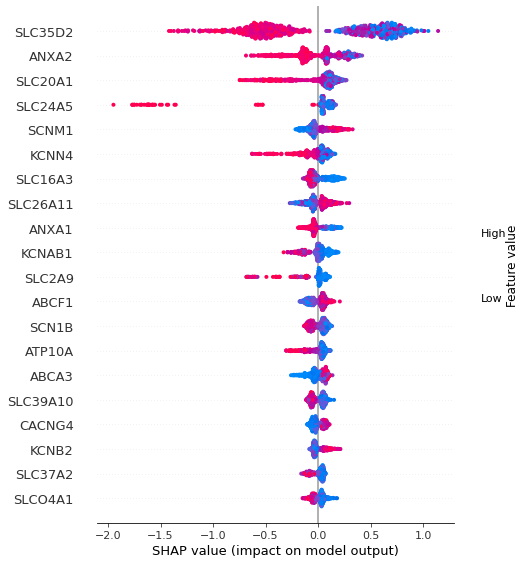

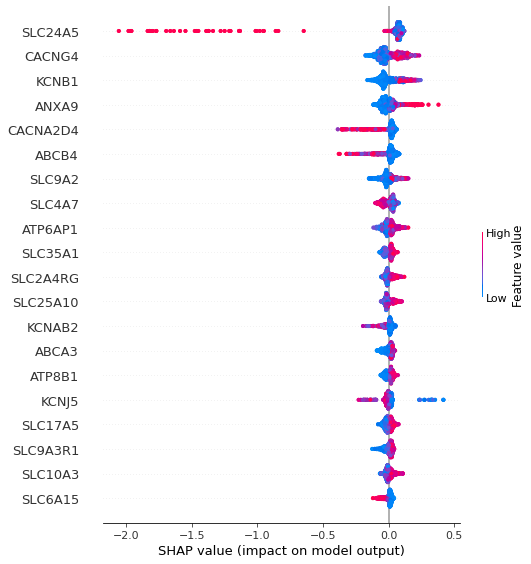

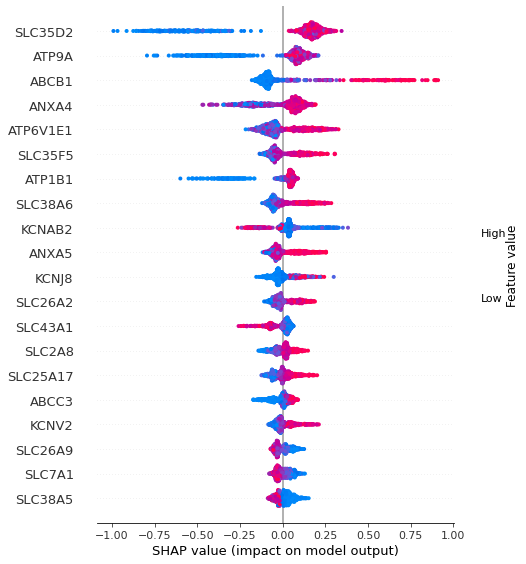

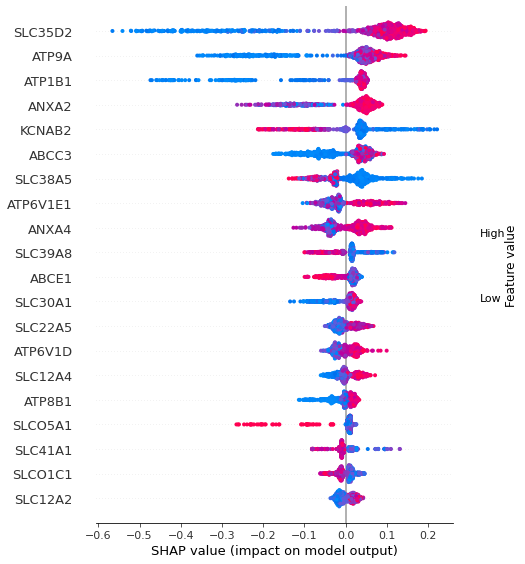

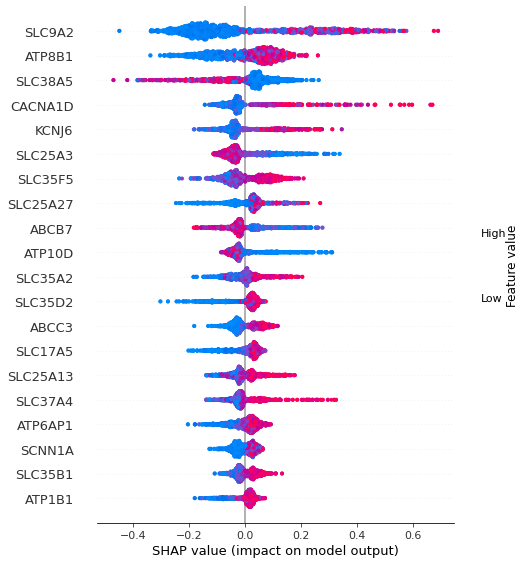

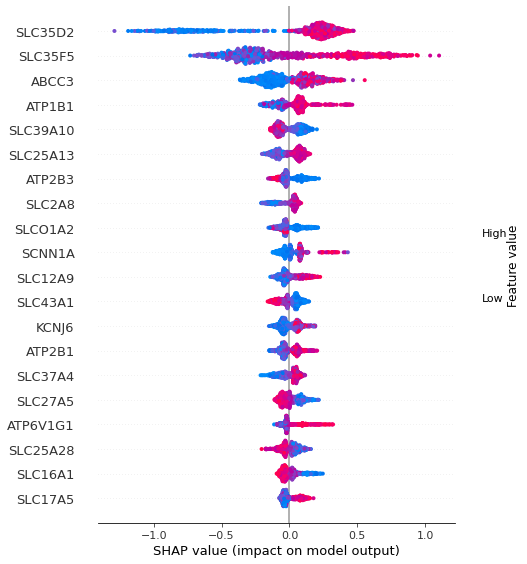

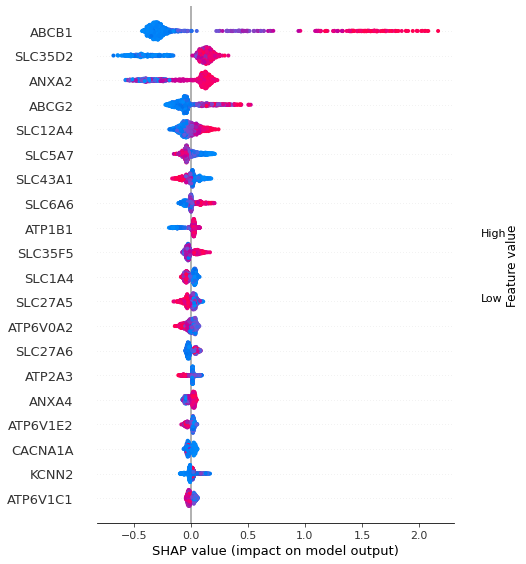

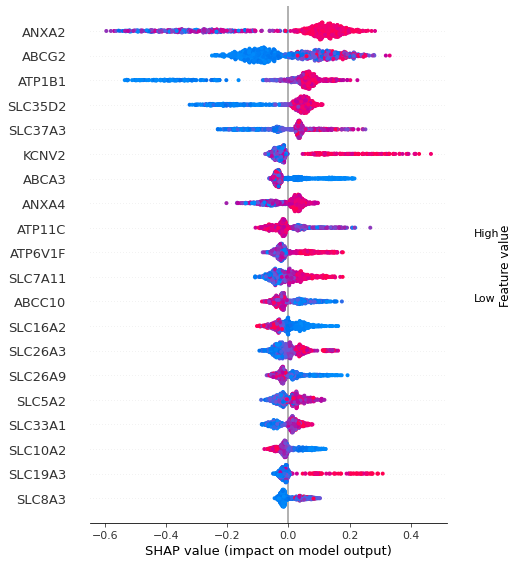

In [48]:
for drug in pd.Series(models_r_sq).sort_values(ascending = False)[:10].index:
    plot_shap(drug)
    plt.close()

In [52]:
refametinib_interaction_values = shap.TreeExplainer(all_models['Refametinib'][0]).shap_interaction_values(prep_data('Refametinib'))

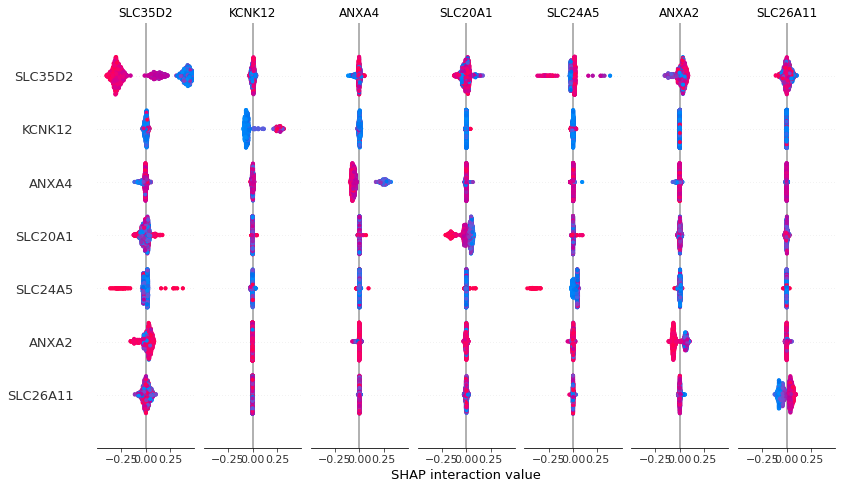

In [53]:
shap.summary_plot(refametinib_interaction_values, prep_data('Refametinib'))

In [58]:
refametinib_interaction_values.max()

0.5674699207892505

In [64]:
print(np.where(expr_matched_transporters.columns == 'SLC35D2'))
print(np.where(expr_matched_transporters.columns == 'ABCB1'))

(array([219], dtype=int64),)
(array([70], dtype=int64),)


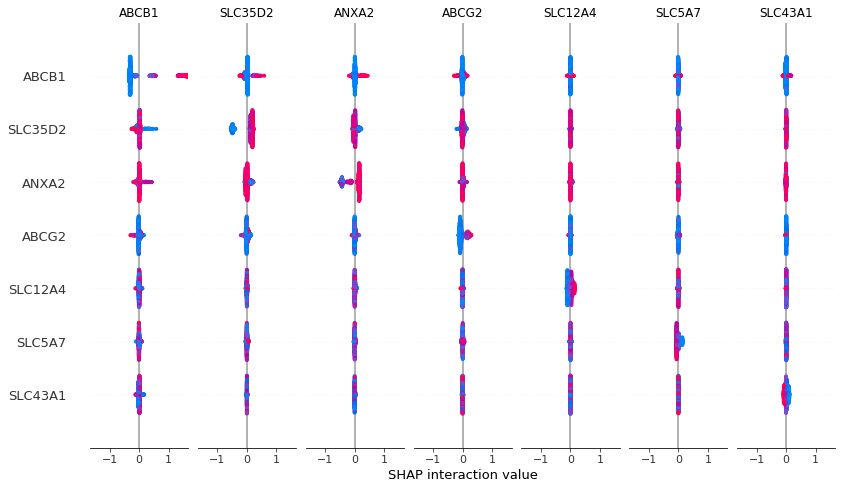

In [65]:
interaction_values_WZ3105 = shap.TreeExplainer(all_models['WZ3105'][0]).shap_interaction_values(prep_data('WZ3105'))
shap.summary_plot(interaction_values_WZ3105, prep_data('WZ3105'))

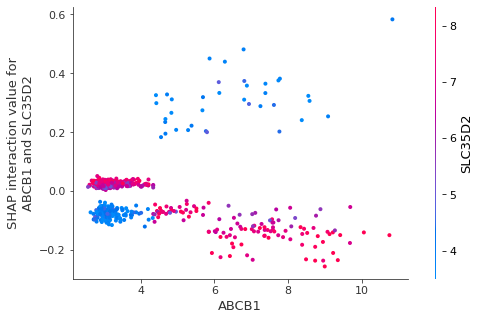

In [66]:
shap.dependence_plot(
    ("ABCB1", "SLC35D2"),
    interaction_values_WZ3105, prep_data('WZ3105'),
    display_features= prep_data('WZ3105')
)

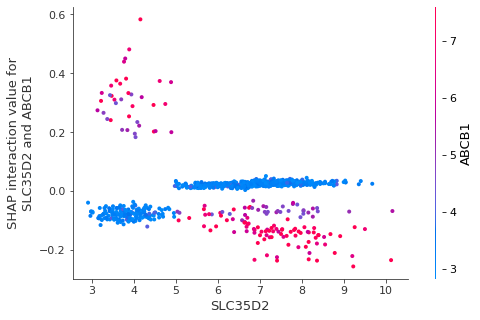

In [67]:
shap.dependence_plot(
    ("SLC35D2", "ABCB1"),
    interaction_values_WZ3105, prep_data('WZ3105'),
    display_features= prep_data('WZ3105')
)